# Tree-based models with SMOTE (Oversampling)

In this notebook tree-based models such as Random Forest, Gradient Boosting and XGBoost are evaluated using SMOTE (oversampling) method. Note that everything in this notebook is pretty similar to the undersampling notebook, however since SMOTE method takes a very long time to train using cross-validation, we decided to separate these notebooks.

In [21]:
# !pip install imblearn
# !pip install xgboost
# !pip install shap

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, make_scorer, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from xgboost import XGBClassifier

from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE

In [3]:
# Reading the preprocessed data
pd.set_option('display.max_columns', 200)
df = pd.read_csv('preprocessed.csv')
df.head()

,Unnamed: 0,age,time_in_hospital,number_diagnoses,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,admission_type_id_1,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,discharge_disposition_id_1,discharge_disposition_id_10,discharge_disposition_id_12,discharge_disposition_id_15,discharge_disposition_id_16,discharge_disposition_id_17,discharge_disposition_id_18,discharge_disposition_id_2,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_24,discharge_disposition_id_25,discharge_disposition_id_27,discharge_disposition_id_28,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_8,discharge_disposition_id_9,admission_source_id_1,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_17,admission_source_id_2,admission_source_id_20,admission_source_id_22,admission_source_id_25,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,payer_code_BC,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_FR,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_UNK,payer_code_WC,medical_specialty_Cardiology,medical_specialty_Emergency/Trauma,medical_specialty_Family/GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics-Reconstructive,medical_specialty_Others,medical_specialty_Radiologist,medical_specialty_Surgery-General,medical_specialty_UNK,diag_1_410,diag_1_414,diag_1_427,diag_1_428,diag_1_486,diag_1_491,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_Others,diag_2_250,diag_2_276,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_427,diag_2_428,diag_2_496,diag_2_599,diag_2_Others,diag_3_250,diag_3_272,diag_3_276,diag_3_401,diag_3_403,diag_3_414,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_Others,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,metformin_Down,metformin_No,metformin_Steady,metformin_Up,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,chlorpropamide_Down,chlorpropamide_No,chlorpropamide_Steady,chlorpropamide_Up,glimepiride_Down,glimepiride_No,glimepiride_Steady,glimepiride_Up,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,acarbose_Down,acarbose_No,acarbose_Steady,acarbose_Up,miglitol_Down,miglitol_No,miglitol_Steady,miglitol_Up,tolazamide_No,tolazamide_Steady,tolazamide_Up,insulin_Down,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_Down,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,readmitted_<30,readmitted_>30,readmitted_NO
0,0,5,1,1,41,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1
1,1,15,3,9,59,0,18,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,

Since preprocessed file included all original columns plus the one-hot features, we can only select the columns that we need for training our model:

In [4]:
df = df.drop(df.columns[0],axis=1)
print(df.shape)
df.head()

(99340, 194)


,age,time_in_hospital,number_diagnoses,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,admission_type_id_1,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,discharge_disposition_id_1,discharge_disposition_id_10,discharge_disposition_id_12,discharge_disposition_id_15,discharge_disposition_id_16,discharge_disposition_id_17,discharge_disposition_id_18,discharge_disposition_id_2,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_24,discharge_disposition_id_25,discharge_disposition_id_27,discharge_disposition_id_28,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_8,discharge_disposition_id_9,admission_source_id_1,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_17,admission_source_id_2,admission_source_id_20,admission_source_id_22,admission_source_id_25,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,payer_code_BC,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_FR,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_UNK,payer_code_WC,medical_specialty_Cardiology,medical_specialty_Emergency/Trauma,medical_specialty_Family/GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics-Reconstructive,medical_specialty_Others,medical_specialty_Radiologist,medical_specialty_Surgery-General,medical_specialty_UNK,diag_1_410,diag_1_414,diag_1_427,diag_1_428,diag_1_486,diag_1_491,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_Others,diag_2_250,diag_2_276,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_427,diag_2_428,diag_2_496,diag_2_599,diag_2_Others,diag_3_250,diag_3_272,diag_3_276,diag_3_401,diag_3_403,diag_3_414,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_Others,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,metformin_Down,metformin_No,metformin_Steady,metformin_Up,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,chlorpropamide_Down,chlorpropamide_No,chlorpropamide_Steady,chlorpropamide_Up,glimepiride_Down,glimepiride_No,glimepiride_Steady,glimepiride_Up,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,acarbose_Down,acarbose_No,acarbose_Steady,acarbose_Up,miglitol_Down,miglitol_No,miglitol_Steady,miglitol_Up,tolazamide_No,tolazamide_Steady,tolazamide_Up,insulin_Down,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_Down,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,readmitted_<30,readmitted_>30,readmitted_NO
0,5,1,1,41,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1
1,15,3,9,59,0,18,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0

In [5]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

print(df_train.shape,df_test.shape)
print(df_train.shape,df_test.shape)

(79472, 194) (19868, 194)
(79472, 194) (19868, 194)


In [6]:
#Helper function to calculate the prevalence of the classes
def calculate_prevalence(y):
    print(sum(y)/len(y))

We can see that proportion of the readmitted class to non-readmitted after partitioning the dataset remains the same and is about 11%.

## Evaluating Models Using Oversampling

There are two main to deal with imbalanced dataset: undersampling and oversampling. In this file we try the oversampling method. Though we don't do this on the whole training set right now since we want to use cross-validation for evaluating the models.

In [7]:
# Shuffling the dataset
df_train = df_train.sample(frac=1,random_state=42).reset_index(drop=True)
df_train.head()

,age,time_in_hospital,number_diagnoses,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,admission_type_id_1,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,discharge_disposition_id_1,discharge_disposition_id_10,discharge_disposition_id_12,discharge_disposition_id_15,discharge_disposition_id_16,discharge_disposition_id_17,discharge_disposition_id_18,discharge_disposition_id_2,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_24,discharge_disposition_id_25,discharge_disposition_id_27,discharge_disposition_id_28,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_8,discharge_disposition_id_9,admission_source_id_1,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_17,admission_source_id_2,admission_source_id_20,admission_source_id_22,admission_source_id_25,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,payer_code_BC,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_FR,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_UNK,payer_code_WC,medical_specialty_Cardiology,medical_specialty_Emergency/Trauma,medical_specialty_Family/GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics-Reconstructive,medical_specialty_Others,medical_specialty_Radiologist,medical_specialty_Surgery-General,medical_specialty_UNK,diag_1_410,diag_1_414,diag_1_427,diag_1_428,diag_1_486,diag_1_491,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_Others,diag_2_250,diag_2_276,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_427,diag_2_428,diag_2_496,diag_2_599,diag_2_Others,diag_3_250,diag_3_272,diag_3_276,diag_3_401,diag_3_403,diag_3_414,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_Others,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,metformin_Down,metformin_No,metformin_Steady,metformin_Up,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,chlorpropamide_Down,chlorpropamide_No,chlorpropamide_Steady,chlorpropamide_Up,glimepiride_Down,glimepiride_No,glimepiride_Steady,glimepiride_Up,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,acarbose_Down,acarbose_No,acarbose_Steady,acarbose_Up,miglitol_Down,miglitol_No,miglitol_Steady,miglitol_Up,tolazamide_No,tolazamide_Steady,tolazamide_Up,insulin_Down,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_Down,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,readmitted_<30,readmitted_>30,readmitted_NO
0,85,3,5,28,2,16,3,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1
1,85,7,9,56,0,18,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0

Let's seperate the dataframe into labels(y) and features (X): 

In [9]:
# Having the training set as dataframe
all_X_train = df_train.iloc[:,:-3]

# Having the training set as numpy arrays
X_train = df_train.iloc[:,:-3].values
X_test = df_test.iloc[:,:-3].values

y_train = df_train.iloc[:,-3].values
y_test = df_test.iloc[:,-3].values

print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)
calculate_prevalence(y_train)

(79472, 191) (79472,) (19868, 191) (19868,)
0.11421632776323737


To make sure that different size in the variables is not going to make a problem in any of the models, we should normalize them. One way to do that is to use the standard scaler which removes the mean and scales down to unit variance.

In [10]:
scaler  = StandardScaler()
scaler.fit(X_train)
X_train_tf = scaler.transform(X_train)
X_test_tf = scaler.transform(X_test)

In this project we our going to compare and evalute results for three different tree-based models, namely: Random Forest classifier, Gradient Boosting Classifier and XGBoost classifier. To evalute them we use 5-fold stratified cross-validation. Also, the main think to keep in mind is that when using oversampling or undersampling techniques, one must make sure that only the training partitions in the cross-validation are modified and not the validation partition. The shortest way to do that is to wrap the oversampler in the imblearn's package pipeline and then use that in the cross-validation.

In [11]:
models = [
    RandomForestClassifier(max_depth=3, random_state= 42),
    GradientBoostingClassifier(max_depth=3, random_state= 42),
    XGBClassifier(max_depth=3, random_state= 42)
    
]
kf = 5
cv_df = pd.DataFrame(index=range(kf * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    imba_pipeline = make_pipeline(SMOTE(random_state=42),shuffle(random_state=42), model)
    accuracies = cross_val_score(imba_pipeline, X_train_tf, y_train, scoring='accuracy', cv=kf)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

Now we plot the results of the cross-validation as boxplots for all thre models:

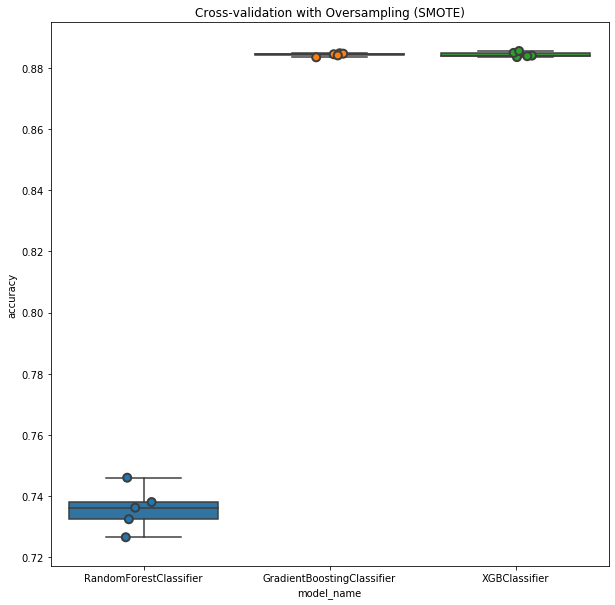

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(x='model_name', y='accuracy', data=cv_df,ax=ax)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,ax=ax, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
ax.set_title('Cross-validation with Oversampling (SMOTE)')
plt.show()

In [13]:
mean_accs = cv_df.groupby('model_name',as_index=False).accuracy.mean()
mean_accs

,model_name,accuracy
0,GradientBoostingClassifier,0.884374
1,RandomForestClassifier,0.735769
2,XGBClassifier,0.884450


As we can see in terms of the accuracy XGBoost classifier is slightly better that the other models.

Before digging deeper into each model, it is better to create some helper functions to help us create more readable plots and results.

In [23]:
# Helper function to print the results
def print_results(y_test, y_pred):
    conf_mat = confusion_matrix(y_test, y_pred)
    labels = ['Not readmiited <30 days', 'readmiited <30 days']
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print(classification_report(y_test, y_pred))

In [17]:
# Helper function to print the important features based on 'gain' (counting
# the number of times a feature is used in all generated trees)
def plot_important_features(model, column_names, num_features, plot_title):
    
    feature_importances = model.feature_importances_

    feature_importances = pd.DataFrame(feature_importances,
                                       index = column_names,
                                        columns=['importance']).sort_values('importance',
                                                                            ascending=False)
    ylocs = np.arange(num_features)

    values_to_plot = feature_importances.iloc[:num_features].values.ravel()[::-1]
    feature_labels = list(feature_importances.iloc[:num_features].index)[::-1]

    plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
    plt.barh(ylocs, values_to_plot, align = 'center')
    plt.ylabel('Features')
    plt.xlabel('Importance Score')
    plt.title(plot_title)
    plt.yticks(ylocs, feature_labels)
    plt.show()

Now we can evaluate the models on the test set. To do that we need to run the model on the oversampled version.

In [18]:
# Oversampling and shuffling the training set to see the results on the testset
oversample = SMOTE(random_state=42)
X_train_os, y_train_os = oversample.fit_resample(X_train_tf, y_train)
X_train_os, y_train_os = shuffle(X_train_os, y_train_os, random_state=42)

## XGBoost Model Results

In [ ]:
# XGBoost results on the test set
xgb_model = models[2]
xgb_model.fit(X_train_os, y_train_os)

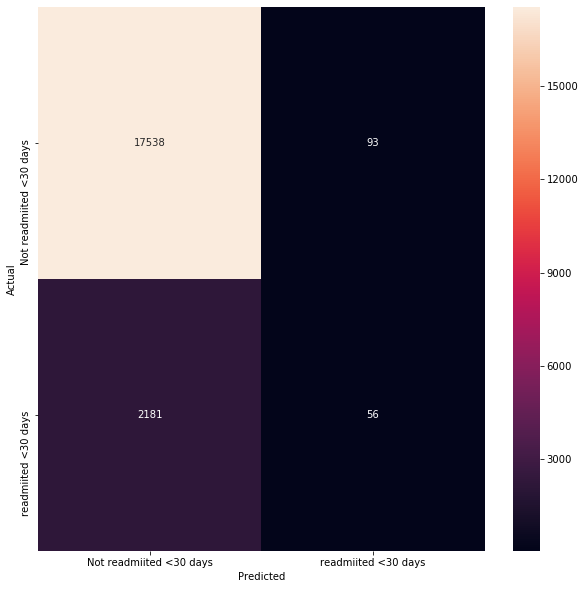

              precision    recall  f1-score   support

           0       0.89      0.99      0.94     17631
           1       0.38      0.03      0.05      2237

    accuracy                           0.89     19868
   macro avg       0.63      0.51      0.49     19868
weighted avg       0.83      0.89      0.84     19868



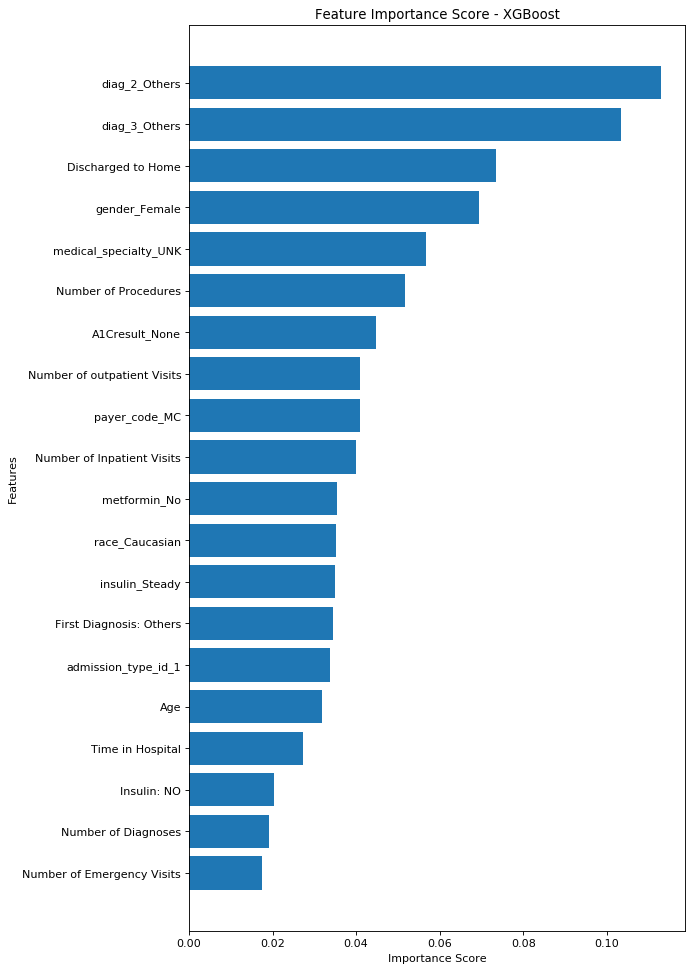

In [24]:
xgb_y_pred = xgb_model.predict(X_test_tf)
print_results(y_test, xgb_y_pred)
plot_important_features(xgb_model, list(all_X_train.columns), 20, 'Feature Importance Score - XGBoost')

In [25]:
roc_auc_score(y_test, xgb_y_pred)

0.5098793634885439

## Gradien Boosting Model Results

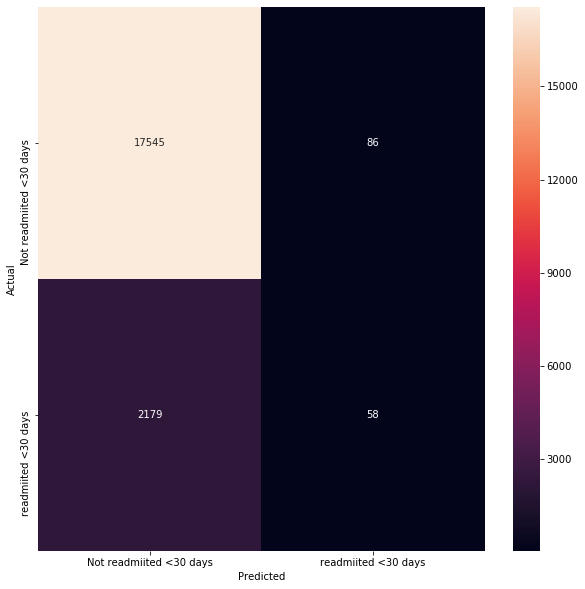

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     17631
           1       0.40      0.03      0.05      2237

    accuracy                           0.89     19868
   macro avg       0.65      0.51      0.49     19868
weighted avg       0.83      0.89      0.84     19868



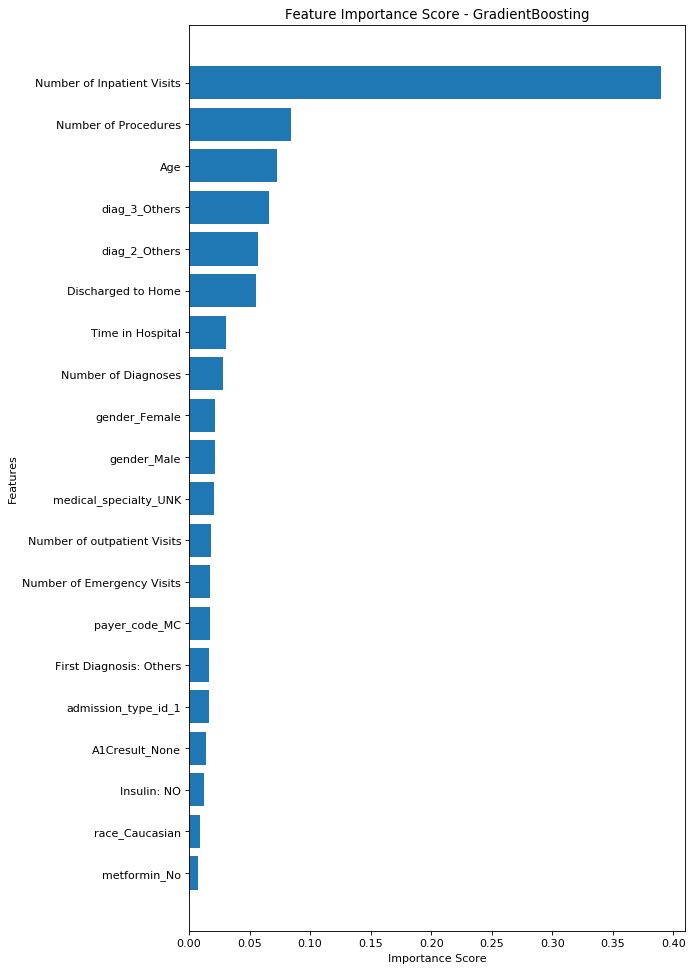

In [26]:
# Gradient Boosting results on the test set
gb_model = models[1]
gb_model.fit(X_train_os, y_train_os)  

gb_y_pred = gb_model.predict(X_test_tf)
print_results(y_test, gb_y_pred)
plot_important_features(gb_model, list(all_X_train.columns), 20, 'Feature Importance Score - GradientBoosting')

In [27]:
roc_auc_score(y_test, gb_y_pred)

0.5105249047382634

## Random Forest Model Results

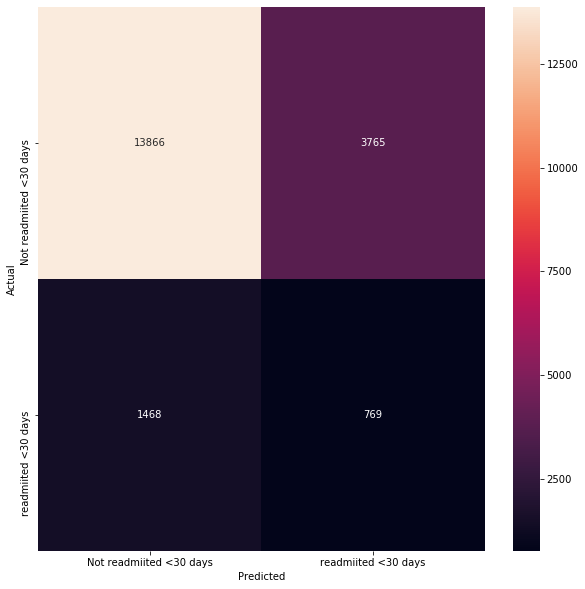

              precision    recall  f1-score   support

           0       0.90      0.79      0.84     17631
           1       0.17      0.34      0.23      2237

    accuracy                           0.74     19868
   macro avg       0.54      0.57      0.53     19868
weighted avg       0.82      0.74      0.77     19868



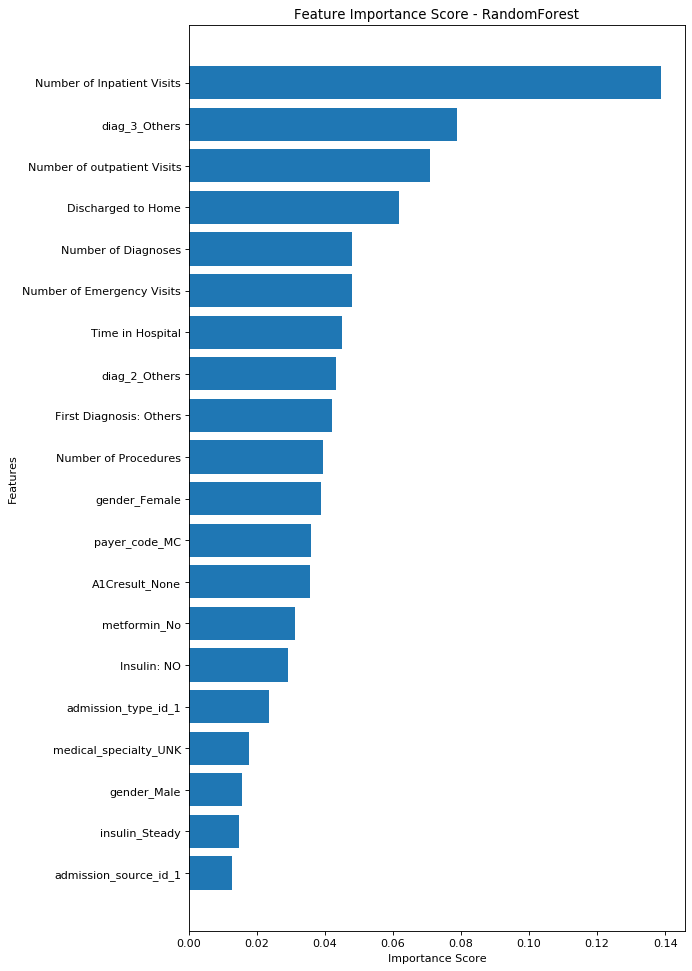

In [28]:
# Random Forest results on the test set
rf_model = models[0]
rf_model.fit(X_train_os, y_train_os)  

rf_y_pred = rf_model.predict(X_test_tf)
print_results(y_test, rf_y_pred)
plot_important_features(rf_model, list(all_X_train.columns), 20, 'Feature Importance Score - RandomForest')

In [29]:
roc_auc_score(y_test, rf_y_pred)

0.565109822133045

## Conclusion
We can see that even though SMOTE oversampling resulted in high accuracies, the recall of the models were pretty low. this might be mainly beacuse SMOTE uses k-nearset neighbors underhood to generate new data, and since the number of features we are using is really large, it fails to generate meaningful samples because of the curse of dimensionality and therefore the results are actually close to when a model is trained on an imbalanced data (it is biased towards the negative class rather than the positive class).<br>
Since in this project prediction of being readmitted is important for us and also since SMOTE oversampling takes a lot more time to optimize and train, we decided to continue with random undersampling in the other notebook.